In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
import torch.utils.data as data

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
1


# Load the VOC2012 dataset

In [4]:
import requests
from tqdm import tqdm

In [5]:
def download_file(url, local_filename):
    # NOTE the stream=True parameter
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in tqdm(r.iter_content(chunk_size=1024)): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                #f.flush() commented by recommendation from J.F.Sebastian
    return local_filename

In [6]:
import os

if not os.path.isdir("/scratch/yardima/datasets/"):
    os.mkdir("/scratch/yardima/datasets/")
    
if not os.path.isdir("/scratch/yardima/datasets/voc12"):
    os.mkdir("/scratch/yardima/datasets/voc12")

In [21]:
download_file("http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar",
              "/scratch/yardima/datasets/voc2012.tar")

1952773it [00:44, 43486.89it/s]


'/scratch/yardima/datasets/voc2012.tar'

In [7]:
import tarfile

In [8]:
def extract_tar_file(fname, path):
    with tarfile.open(fname) as f:
        f.extractall(path=path)    

In [26]:
extract_tar_file("/scratch/yardima/datasets/voc2012.tar", "/scratch/yardima/datasets/voc12/")

In [18]:
download_file("http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz",
              "/scratch/yardima/datasets/bsd_bench.tar")

1386270it [01:22, 16904.29it/s]


'/scratch/yardima/datasets/bsd_bench.tar'

In [19]:
extract_tar_file("/scratch/yardima/datasets/bsd_bench.tar", "/scratch/yardima/datasets/")

In [4]:
import ptsemseg
import ptsemseg.loader

In [146]:
data_loader = ptsemseg.loader.get_loader("pascal")

data_aug = None

t_loader = data_loader(
        "/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
        is_transform=True,
        split="train_aug",
        img_size=('same', 'same'),
        augmentations=data_aug)


v_loader = data_loader("/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
                        is_transform=True,
                        split="val",
                        img_size=('same', 'same'),
                        img_norm=False)

trainloader = data.DataLoader(t_loader,
                                  batch_size=1,
                                  num_workers=2,
                                  shuffle=True)

valloader = data.DataLoader(v_loader,
                                batch_size=1,
                                num_workers=2)

# Load the PSPNet model

In [147]:
import ptsemseg.models

In [148]:
pspnet = ptsemseg.models.get_model({"arch": "pspnet"}, n_classes=21)

In [149]:
parameters = 0
for p in pspnet.parameters():
    parameters += p.numel()

print("Number of parameters: {}".format(parameters))

Number of parameters: 68073706


In [150]:
pspnet.load_pretrained_model("/srv/glusterfs/yardima/runs/pretrained-models/pspnet101_VOC2012.caffemodel")

Processing layer conv1_1_3x3_s2
Processing layer conv1_1_3x3_s2/bn
Processing layer conv1_2_3x3
Processing layer conv1_2_3x3/bn
Processing layer conv1_3_3x3
Processing layer conv1_3_3x3/bn
Processing layer conv2_1_1x1_reduce
Processing layer conv2_1_1x1_reduce/bn
Processing layer conv2_1_3x3
Processing layer conv2_1_3x3/bn
Processing layer conv2_1_1x1_increase
Processing layer conv2_1_1x1_increase/bn
Processing layer conv2_1_1x1_proj
Processing layer conv2_1_1x1_proj/bn
Processing layer conv2_2_1x1_reduce
Processing layer conv2_2_1x1_reduce/bn
Processing layer conv2_2_3x3
Processing layer conv2_2_3x3/bn
Processing layer conv2_2_1x1_increase
Processing layer conv2_2_1x1_increase/bn
Processing layer conv2_3_1x1_reduce
Processing layer conv2_3_1x1_reduce/bn
Processing layer conv2_3_3x3
Processing layer conv2_3_3x3/bn
Processing layer conv2_3_1x1_increase
Processing layer conv2_3_1x1_increase/bn
Processing layer conv3_1_1x1_reduce
Processing layer conv3_1_1x1_reduce/bn
Processing layer con

In [120]:
pspnet.cuda();
pspnet.eval();

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x2b46ab9f8550>>
Traceback (most recent call last):
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/yardima/.pye

torch.Size([1, 3, 256, 256])


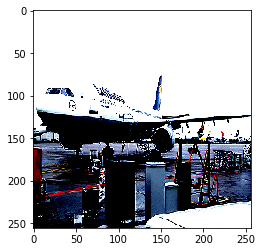

In [130]:
dataiter = iter(valloader)
i, l = dataiter.next()
print(i.shape)
g = torchvision.utils.make_grid(i, nrow=4)

#g = g / 2 + 0.5     # unnormalize
npimg = g.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

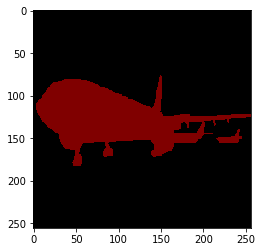

In [131]:
v_loader.decode_segmap(l.numpy().reshape((l.shape[1], l.shape[2])), plot=True)

In [135]:
ig = i.to(device)

ig = ig * 15

ig.cuda()
pspnet.train(False)

with torch.autograd.no_grad():
    img = ig.clone()
    out = pspnet.forward(img)

In [136]:
print(out.shape)

torch.Size([1, 21, 256, 256])


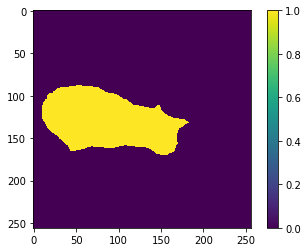

In [137]:
output = out.cpu().data[0].numpy()
#output = output[:,:img_temp.shape[0],:img_temp.shape[1]]
output = output.transpose(1,2,0)
output = output[:,:,0:]
output = np.argmax(output,axis = 2)
#output = output[:,:,1]

# plt.subplot(3, 1, 1)
# plt.imshow(img_original)
# plt.subplot(3, 1, 2)
# plt.imshow(gt)
# plt.subplot(3, 1, 3)
plt.imshow(output)
plt.colorbar()
plt.show()

In [30]:
output

array([[18, 18, 18, ..., 18, 18, 18],
       [18, 18, 18, ..., 18, 18, 18],
       [18, 18, 18, ..., 18, 18, 18],
       ...,
       [18, 18, 18, ..., 18, 18, 18],
       [18, 18, 18, ..., 18, 18, 18],
       [18, 18, 18, ..., 18, 18, 18]])

## Find used mean/std

In [138]:
pspnet.eval();
pspnet = pspnet.cuda()

In [22]:
mean_tensor = torch.tensor(np.random.randn(1, 3, 1, 1) - 0.5, requires_grad=True, dtype=torch.float32, device=device) 
std_tensor = torch.tensor(np.random.randn(1, 3, 1, 1) * 2 + 10, requires_grad=True, dtype=torch.float32, device=device)

In [23]:
pspnet.cuda()
optimizer = optim.SGD([mean_tensor, std_tensor], lr=1e-2, momentum=0.9)

In [24]:
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 4, 6], gamma=0.1)

In [151]:
for p in pspnet.parameters():
    p.to(device)

In [112]:
for epoch in range(5):
    scheduler.step()
    i = 1
    running_loss = 0.0
    
    print("Epoch {}".format(epoch))
    for (images, labels) in trainloader:
        images = images.cuda()
        labels = labels.cuda()
        
        itransformed = images * std_tensor + mean_tensor
        
        optimizer.zero_grad()
        
        out = pspnet.forward(itransformed)
      
        loss = ptsemseg.loss.cross_entropy2d(out, labels)
        
        loss.backward()

        optimizer.step()
        
        running_loss += loss.item()
        
        del loss, out
        
        if i % 100 == 0:
            print(running_loss / 100)
            running_loss = 0.0
            
        i += 1

Epoch 0


TypeError: 'int' object is not subscriptable

In [27]:
torch.save([mean_tensor, std_tensor], '/home/yardima/norm_param1')

In [29]:
mean_tensor

tensor([[[[-0.0531]],

         [[-0.9113]],

         [[-1.4369]]]], device='cuda:0', requires_grad=True)

In [30]:
std_tensor

tensor([[[[15.1530]],

         [[18.5970]],

         [[17.2651]]]], device='cuda:0', requires_grad=True)

## Eval PSPNet

In [139]:
def _fast_hist(label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask],
            minlength=n_class ** 2,
        ).reshape(n_class, n_class)
        return hist

In [140]:
i.numel()/ 3

65536.0

In [141]:
(1.0 * (out == l))

RuntimeError: Expected object of type torch.cuda.FloatTensor but found type torch.LongTensor for argument #2 'other'

In [155]:
pspnet = pspnet.cuda()

In [156]:
pspnet.train(mode=False);

In [157]:
%%time

n_class = 21
image_count = 0
acc = 0.
cf_matrix = np.zeros(shape=(n_classes, n_classes), dtype=np.float64)
with torch.no_grad():
    for i, l in valloader:
        i = i.cuda()
        
        i[:, 0, :, :] = (i[:, 0, :, :] * 0.229) * 255
        i[:, 1, :, :] = (i[:, 1, :, :] * 0.224) * 255
        i[:, 2, :, :] = (i[:, 2, :, :] * 0.225) * 255

        out =  pspnet.forward(i).cpu().numpy()
        
        out = out.squeeze().transpose(1,2,0)
        out = np.argmax(out,axis = 2)
        
        acc += np.sum(out == l.numpy()) / (i.numel() / 3)
        
        out = out.reshape(-1)
        l = l.numpy().reshape(-1)
        cf_matrix += _fast_hist(l, out, n_class)
        
        image_count += 1
        
        
acc /= image_count
cf_matrix /= np.sum(cf_matrix)
hist = cf_matrix
mean_iu = np.nanmean(np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)))

CPU times: user 1min 52s, sys: 30.9 s, total: 2min 23s
Wall time: 2min 44s


In [158]:
print("Pixel Acc.: {}".format(acc))
print("Mean IOU: {}".format(mean_iu))

Pixel Acc.: 0.9442063763908378
Mean IOU: 0.7705580880185501


In [ ]:
plt.